# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import math
import json
import scipy.stats as st
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
#read in list of available cities from openweathermap.org this is used to prevent us from calling the API for cities it is not aware of.

with open('city.list.json',encoding='utf-8') as f:
  data = json.load(f)

openweather_cities = {}

for city in data:
    openweather_cities[city['id']] = city['name'].lower() + "," + city["country"].lower()
    
print(f"openweather API supports {len(openweather_cities)} cities")


openweather API supports 209579 cities


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1])
    cityname = city.city_name.lower()
    countrycode = city.country_code
    fullname = cityname + "," + countrycode
    
    # If the city is unique, then add it to a our cities list
    if (city not in cities) and (fullname in openweather_cities.values()):
            cities.append(fullname)

# Print the city count to confirm sufficient count
len(cities)
        

1182

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
def getCityID(dictOfElements, valueToFind):
    listOfItems = dictOfElements.items()
    for item in listOfItems:
        if item[1] == valueToFind:
            return item[0]


In [5]:
def getCityName(longName):
    return longName.split(",")[0].capitalize()

In [6]:
#Using historic weather API (https://openweathermap.org/history)

# Starting URL for Weather Map API Call
weather_url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial"

city_data = []
counter = 0

for city in cities:
    cityname = getCityName(city)
    cityid = getCityID(openweather_cities,city)
    
    print(f"Collecting data for city {counter}/{len(cities)}: {cityname}({cityid})")
    
    city_url = weather_url + "&q=" + city + "&appid=" + weather_api_key
    try:
        city_weather = requests.get(city_url).json()
        city_latitude = city_weather['coord']['lat']
        city_mtemp = city_weather['main']['temp_max']
        city_humidity = city_weather['main']['humidity']
        city_cloudiness = city_weather['clouds']['all']
        city_wspeed = city_weather['wind']['speed']
        city_name = city_weather['name']
        city_id = city_weather['id']
        city_data.append({"City":city_name.capitalize(),
                          "ID": city_id,
                      "Latitude":city_latitude,
                      "Max Temp":city_mtemp,
                      "Humidity":city_humidity,
                      "Cloudiness":city_cloudiness,
                      "Wind Speed":city_wspeed,
                      })
        counter = counter + 1
    except:
        print(f"Error calling: {city_url}")
        pass

print(f"Finished collecting data for {len(city_data)} cities")


Error calling: http://api.openweathermap.org/data/2.5/weather?units=Imperial&q=simeykyne,ua&appid=79c0817f7416ec5514216119ab7a973c


Finished collecting data for 1181 cities


In [7]:
#creating a dataframe
raw_weather_data = pd.DataFrame(city_data)

# Save data frame to CSV
raw_weather_data.to_csv('../output_data/raw_weather_data.csv')

# re arranging the columns in data frame 
raw_weather_data = raw_weather_data [["City","ID","Cloudiness","Humidity","Latitude","Max Temp","Wind Speed"]]
raw_weather_data.head()

,City,ID,Cloudiness,Humidity,Latitude,Max Temp,Wind Speed
0,San cristobal,3651949,41,84,-0.90,71.01,10.00
1,Grand gaube,934479,53,79,-20.01,72.00,5.01
2,Saint paul harbor,5866583,90,62,57.79,55.40,17.22
3,Albany,2077963,90,87,-35.02,59.00,17.22
4,Kununurra,2068110,85,20,-15.77,84.20,13.87


#Inspect the data and remove the cities where the humidity > 100%.
#Skip this step if there are no cities that have humidity > 100%.

In [8]:
clean_weather_data = raw_weather_data[raw_weather_data['Humidity'] <= 100] 
clean_weather_data.to_csv('../output_data/clean_weather_data.csv')
clean_weather_data


,City,ID,Cloudiness,Humidity,Latitude,Max Temp,Wind Speed
0,San cristobal,3651949,41,84,-0.90,71.01,10.00
1,Grand gaube,934479,53,79,-20.01,72.00,5.01
2,Saint paul harbor,5866583,90,62,57.79,55.40,17.22
3,Albany,2077963,90,87,-35.02,59.00,17.22
4,Kununurra,2068110,85,20,-15.77,84.20,13.87
...,...,...,...,...,...,...,...
1176,Kruisfontein,986717,51,68,-34.00,53.24,21.07
1177,Avarua,4035715,0,64,-21.21,75.20,12.75
1178,Saldanha,3361934,56,76,-33.01,57.20,5.82
1179,Fortuna,5563839,90,76,40.60,57.99,12.75


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

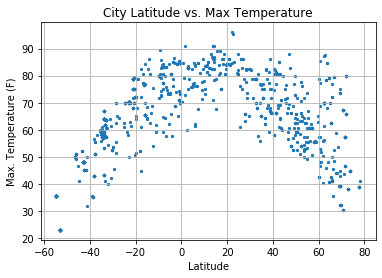

In [9]:
#Temperature (F) vs. Latitude
plt.scatter(clean_weather_data["Latitude"], clean_weather_data["Max Temp"], marker="o", s=5)
plt.title("City Latitude vs. Max Temperature")
plt.xlabel("Latitude")
plt.ylabel("Max. Temperature (F)")
plt.grid(True)

plt.savefig("../output_data/Temperature_vs_Latitude.png")
plt.show()


## Latitude vs. Humidity Plot

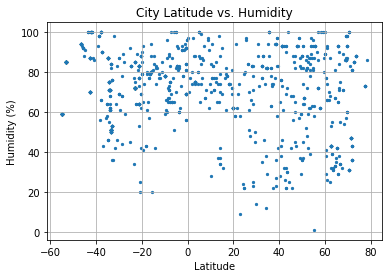

In [10]:
# Humidity (%) vs. Latitude
plt.scatter(clean_weather_data["Latitude"], clean_weather_data["Humidity"], marker="o", s=5)
plt.title("City Latitude vs. Humidity")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid(True)

plt.savefig("../output_data/Humidity_vs_Latitude.png")
plt.show()

Latitude vs. Cloudiness Plot

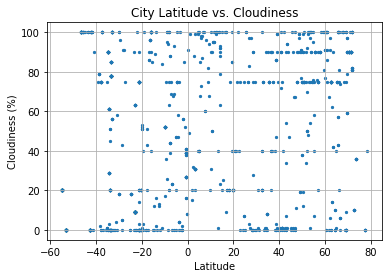

In [11]:
# Cloudiness (%) vs. Latitude
plt.scatter(clean_weather_data["Latitude"], clean_weather_data["Cloudiness"], marker="o", s=5)
plt.title("City Latitude vs. Cloudiness")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid(True)

plt.savefig("../output_data/Cloudiness_vs_Latitude.png")
plt.show()


## Latitude vs. Wind Speed Plot

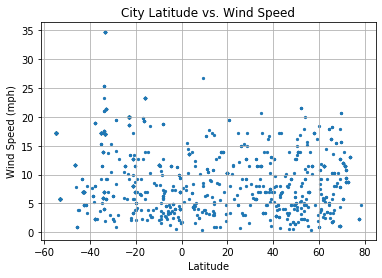

In [12]:
# Wind Speed (mph) vs. Latitude
plt.scatter(clean_weather_data["Latitude"], clean_weather_data["Wind Speed"], marker="o", s=5)
plt.title("City Latitude vs. Wind Speed")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.grid(True)

plt.savefig("../output_data/Wind_Speed_vs_Latitude.png")
plt.show()


## Linear Regression

In [13]:
# OPTIONAL: Create a function to create Linear Regression plots
def linear_agression(x,y):
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    regress_values =  intercept + (x * slope)
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
    plt.scatter(x, y, marker="o", s=5)
    plt.plot(x,regress_values,"r-")
    
    return line_eq

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

In [14]:
# Create Northern and Southern Hemisphere DataFrames
northern_hemisphere = clean_weather_data.loc[clean_weather_data["Latitude"] >= 0]
southern_hemisphere = clean_weather_data.loc[clean_weather_data["Latitude"] < 0]

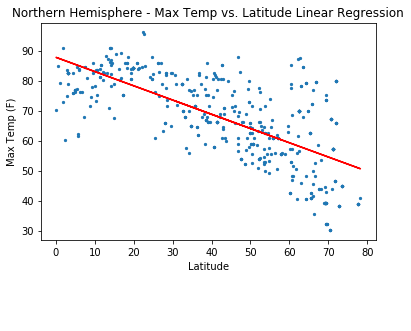

In [15]:
equation = linear_agression(northern_hemisphere["Latitude"], northern_hemisphere["Max Temp"])

plt.title("Northern Hemisphere - Max Temp vs. Latitude Linear Regression")
plt.xlabel("Latitude")
plt.ylabel("Max Temp (F)")
plt.annotate(equation, (0,0),fontsize=12,color="red")
plt.savefig("../output_data/Northern Hemisphere - Max Temp vs. Latitude Linear Regression.png")
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

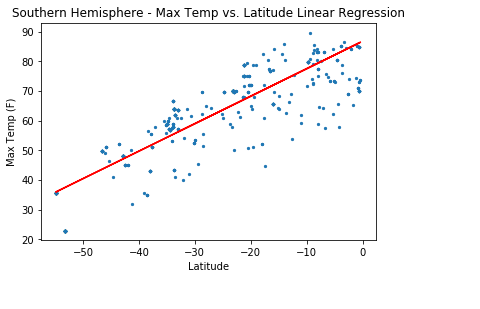

In [16]:
equation = linear_agression(southern_hemisphere["Latitude"], southern_hemisphere["Max Temp"])

plt.title("Southern Hemisphere - Max Temp vs. Latitude Linear Regression")
plt.xlabel("Latitude")
plt.ylabel("Max Temp (F)")

plt.annotate(equation, (0,0),fontsize=12,color="red")
plt.savefig("../output_data/Southern Hemisphere - Max Temp vs. Latitude Linear Regression.png")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

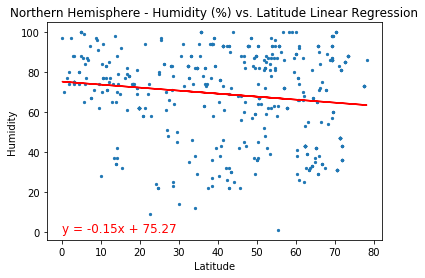

In [17]:
equation = linear_agression(northern_hemisphere["Latitude"], northern_hemisphere["Humidity"])

plt.title("Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression")
plt.xlabel("Latitude")
plt.ylabel("Humidity")

plt.annotate(equation, (0,0),fontsize=12,color="red")
plt.savefig("../output_data/Northern Hemisphere - Humidity vs. Latitude Linear Regression.png")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

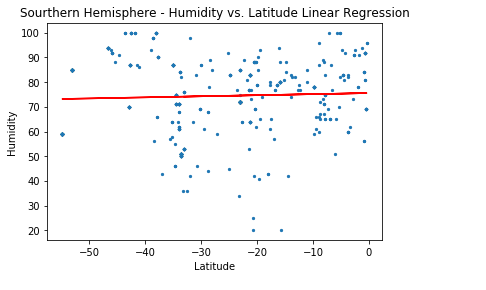

In [18]:
equation = linear_agression(southern_hemisphere["Latitude"], southern_hemisphere["Humidity"])

plt.title("Sourthern Hemisphere - Humidity vs. Latitude Linear Regression")
plt.xlabel("Latitude")
plt.ylabel("Humidity")

plt.annotate(equation, (0,0),fontsize=12,color="red")
plt.savefig("../output_data/Sourthern Hemisphere - Humidity vs. Latitude Linear Regression.png")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

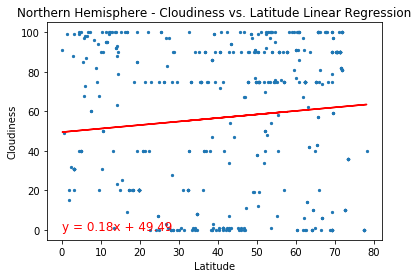

In [19]:
equation = linear_agression(northern_hemisphere["Latitude"], northern_hemisphere["Cloudiness"])

plt.title("Northern Hemisphere - Cloudiness vs. Latitude Linear Regression")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")

plt.annotate(equation, (0,0),fontsize=12,color="red")
plt.savefig("../output_data/Northern Hemisphere - Cloudiness vs. Latitude Linear Regression.png")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

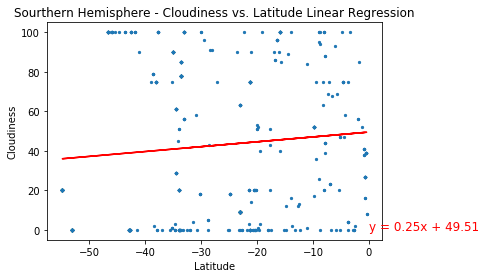

In [20]:
equation = linear_agression(southern_hemisphere["Latitude"], southern_hemisphere["Cloudiness"])

plt.title("Sourthern Hemisphere - Cloudiness vs. Latitude Linear Regression")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")

plt.annotate(equation, (0,0),fontsize=12,color="red")
plt.savefig("../output_data/Sourthern Hemisphere - Cloudiness vs. Latitude Linear Regression.png")
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

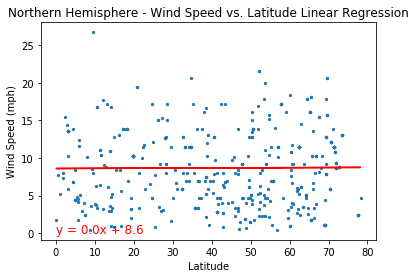

In [21]:
equation = linear_agression(northern_hemisphere["Latitude"], northern_hemisphere["Wind Speed"])

plt.annotate(equation, (0,0),fontsize=12,color="red")

plt.title("Northern Hemisphere - Wind Speed vs. Latitude Linear Regression")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

plt.savefig("../output_data/Northern Hemisphere - Wind Speed vs. Latitude Linear Regression.png")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

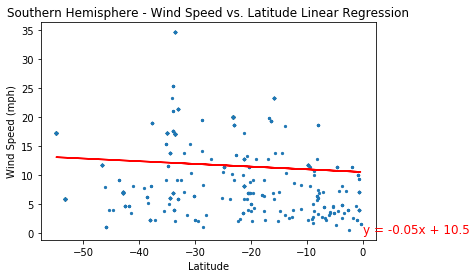

In [22]:
equation = linear_agression(southern_hemisphere["Latitude"], southern_hemisphere["Wind Speed"])

plt.title("Southern Hemisphere - Wind Speed vs. Latitude Linear Regression")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

plt.annotate(equation, (0,0),fontsize=12,color="red")
plt.savefig("../output_data/Southern Hemisphere - Wind Speed vs. Latitude Linear Regression.png")
plt.show()



In [ ]:
#The closer you are to equator the hotter it gets
#Lattitude doesn't really affect humidity, it stays relatively the same. If anything, humidity is higher when lattitude is lower
#Lattitude doesn't really affect wind speed, it stays relatively similar regarless of the lattitude
#The higer the lattitude the higher the cloudiness
